###  Install Required Libraries



In [1]:
"""%pip install torch
%pip install transformers
%pip install torchtext
%pip install openai
%pip install icecream
%pip install tqdm
%pip install tabulate
%pip install requests
%pip install scikit-learn
%pip install nltk
"""

'%pip install torch\n%pip install transformers\n%pip install torchtext\n%pip install openai\n%pip install icecream\n%pip install tqdm\n%pip install tabulate\n%pip install requests\n%pip install scikit-learn\n%pip install nltk\n'

In [2]:
import sys
sys.path.append('../')
from src.evaluation.goal_evaluator import GoalEvaluator
from src.extraction.extractor import generate_description, generate_actors, generate_high_level_goals, generate_low_level_goals
from src.mapping.APIs_mapping import generate_mapping_apis_goals, print_api_goal_mapping
from src.self_critique.refine_response import EvalMode, generate_response_with_reflection
from src.tools import get_api_list_from_swagger
from src.examples.shot_learning import ShotPromptingMode

[nltk_data] Downloading package punkt to /Users/angelo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/angelo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/angelo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/angelo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Experiments

In [3]:
SHOTS_NUMBER = ShotPromptingMode.ONE_SHOT

### Description Generation

In [4]:
print("Description STARTING...")
description = generate_description("https://github.com/WebFuzzing/EMB/tree/master/jdk_8_maven/cs/rest-gui/genome-nexus#readme")
print("Description DONE...")
print(description)

Description STARTING...
Description DONE...
description='Genome Nexus is an innovative tool designed for the fast, automated, and high-throughput annotation and interpretation of genetic variants in cancer. It integrates data from various resources, including databases that facilitate the conversion of DNA changes into protein changes and that predict the functional effects of protein mutations. Furthermore, Genome Nexus contains comprehensive information regarding mutation frequencies, gene functions, variant effects, and clinical actionability, aiming to enhance the accessibility and utility of genetic information in cancer research.'


### Actors Extraction

In [9]:
actors, actors_score, actors_critique = generate_response_with_reflection(
    "Actors",
    generate_actors,
    define_args=description,
    eval_mode=EvalMode.ACTORS,
    eval_args=description,
    shotPromptingMode=SHOTS_NUMBER,
    max_attempts=3
)

Actors STARTING... (attempt 1)
No feedback provided!
Actors DONE...
actors=[Actor(name='Cancer Researchers', description='Individuals conducting research on cancer genetics and variants.'), Actor(name='Geneticists', description='Experts who study gene functions and mutation effects.'), Actor(name='Clinical Oncologists', description='Medical professionals using genetic information for cancer treatment decisions.'), Actor(name='Data Analysts', description='Users analyzing genetic data to derive insights and patterns.')]
Evaluation for Actors STARTING...
Evaluation for Actors DONE...
Score: 8
Critique: The identified actors cover the main roles related to the usage of Genome Nexus, but there's a potential omission of roles such as software developers or bioinformaticians who might be involved in ensuring the tool's functionality and integration. Including these roles would provide a more comprehensive view of all actors involved in the software's ecosystem.
Satisfactory score achieved! Br

### High Level Goals Extraction

In [10]:
highLevelGoals, HL_score, HL_critique = generate_response_with_reflection(
    "High Level Goals",
    generate_high_level_goals,
    define_args=(description, actors),
    eval_mode=EvalMode.HIGH_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors)
)

High Level Goals STARTING... (attempt 1)
No feedback provided!
This is the provided sys prompt:  You are a helpful assistant that helps developers to extract high-level goals from software descriptions. You're tasked with extracting high level goals from a software description, you're also provided with actors that are expected to interact with the software. MUST focus only on functional requirements and ignore non-functional requirements. Focus only on requirements that benefit the end user of the software. The returned high-level goals should be specific and focused on functional user needs.

High Level Goals DONE...
goals=[HighLevelGoal(name='Automated Annotation of Genetic Variants', description='Cancer Researchers aim to quickly and automatically annotate and interpret genetic variants in cancer using Genome Nexus.', actor=Actor(name='Cancer Researchers', description='Individuals conducting research on cancer genetics and variants.')), HighLevelGoal(name='Integration of Genetic Da

### Low Level Goals Extraction

In [11]:
lowLevelGoals, LL_score, LL_critique = generate_response_with_reflection(
    "Low Level Goals",
    generate_low_level_goals,
    define_args=(highLevelGoals),
    eval_mode=EvalMode.LOW_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors, highLevelGoals)
)

Low Level Goals STARTING... (attempt 1)
No feedback provided!
This is the provided sys prompt:  You are a helpful assistant that helps developers to extract low-level goals from high-level goals. The low-level goals that you create MUST be structured to match against a set of API calls. Don't be too generic, for example, avoid goals like 'make the software fast', 'develop a web interface' etc. MUST focus only on functional requirements and ignore non-functional requirements. Focus only on requirements that benefit the end user of the software. The returned low-level goals should be specific and focused on the user's needs.

Low Level Goals DONE...
low_level_goals=[LowLevelGoal(name='Automatically annotate genetic variants identified in cancer research using Genome Nexus.', description='Process genetic variant data through Genome Nexus to obtain annotations without manual intervention, streamlining research efforts for cancer researchers.', high_level_associated=HighLevelGoal(name='Auto

### APIs Extraction from Swagger

In [12]:
print("API List STARTING...")
apiList = get_api_list_from_swagger()
print("API List DONE...")
print(apiList)

API List STARTING...
API List DONE...
[API(api_name='fetchVariantAnnotationPOST', api_path='/annotation', description='Retrieves VEP annotation for the provided list of variants', request_type='post'), API(api_name='fetchVariantAnnotationByIdPOST', api_path='/annotation/dbsnp/', description='Retrieves VEP annotation for the provided list of dbSNP ids', request_type='post'), API(api_name='fetchVariantAnnotationByIdGET', api_path='/annotation/dbsnp/{variantId}', description='Retrieves VEP annotation for the give dbSNP id', request_type='get'), API(api_name='fetchVariantAnnotationByGenomicLocationPOST', api_path='/annotation/genomic', description='Retrieves VEP annotation for the provided list of genomic locations', request_type='post'), API(api_name='fetchVariantAnnotationByGenomicLocationGET', api_path='/annotation/genomic/{genomicLocation}', description='Retrieves VEP annotation for the provided genomic location', request_type='get'), API(api_name='fetchVariantAnnotationGET', api_path=

### APIs Mapping to Low Level Goals

In [13]:
print("Mapping STARTING...")
mappings = generate_mapping_apis_goals(lowLevelGoals, apiList)
print("Mapping DONE")

Mapping STARTING...
hlg name:  Automated Annotation of Genetic Variants
Goal name:  Automatically annotate genetic variants identified in cancer research using Genome Nexus.
Goal description:  Process genetic variant data through Genome Nexus to obtain annotations without manual intervention, streamlining research efforts for cancer researchers.
APIs:  fetchVariantAnnotationPOST, fetchVariantAnnotationByGenomicLocationPOST, fetchVariantAnnotationGET

hlg name:  Integration of Genetic Data
Goal name:  Integrate genetic variant data from multiple sources into Genome Nexus.
Goal description:  Enable the seamless integration of diverse genetic data resources, allowing geneticists to analyze the combined information for better understanding of gene functions.
APIs:  fetchVariantAnnotationPOST, fetchVariantAnnotationByGenomicLocationPOST, fetchEnsemblTranscriptsByEnsemblFilterPOST

hlg name:  Access to Mutation Frequencies and Gene Functions
Goal name:  Access and visualize mutation frequenc

In [ ]:
print(mappings[0].low_level_goal.high_level_associated.name)

name='Automated Annotation of Genetic Variants' description='Cancer Researchers want to quickly and automatically annotate and interpret genetic variants in cancer using Genome Nexus.' actor=Actor(name='Cancer Researchers', description='Individuals conducting research on cancer genetics and variants.')


### Mapping Table

In [14]:
print_api_goal_mapping(mappings)

╒══════════════════════════════════════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Low-Level Goal name                                                                              │ Low-Level Goal description                                                                                                                                                      │ Mapped APIs                                                                                                           │
╞══════════════════════════════════════════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════════════════════════════════════════════

# Evaluation

### Evaluation: Extracted High Level Goals 

In [ ]:
# List of high-level goals 
generated_goals = [goal.description for goal in highLevelGoals.goals]
manual_goals = ["Provide fast and automated annotation of genetic variants", "Enable high-throughput interpretation of genetic variants", "Integrate information from various existing resources", "Convert DNA changes to protein changes", "Predict functional effects of protein mutations", "Provide information about mutation frequencies", "Offer insights into gene function", "Detail variant effects", "Highlight clinical actionability of variants"]

evaluator = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator.print_roc_prec_rec_curve(generated_goals, manual_goals)
print("High Level ROC AUC:", auc_roc)
print("High Level Precision Recall Curve AUC:", auc_prec_rec)


/opt/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Evaluation: Extracted Low Level Goals 

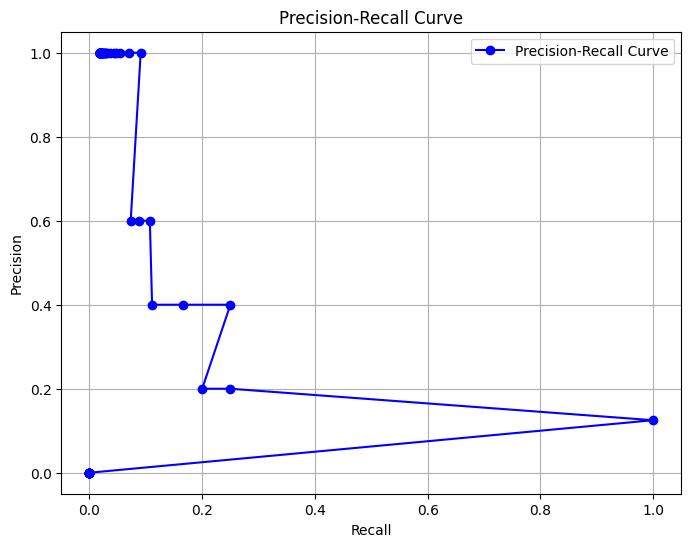

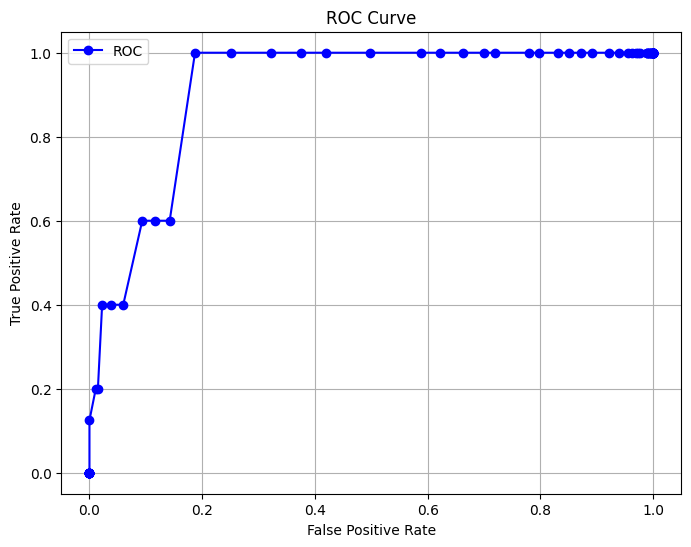

Low Level Goals ROC AUC: 0.9145599249073484
Low Level Goals Precision Recall Curve AUC: 0.20901636119454708


In [ ]:
# List of low-level goals 
generated_low_level_goals = [goal.description for goal in lowLevelGoals.low_level_goals]

manual_low_level_goals = [
    # Provide a comprehensive one-stop resource for genetic variant annotation
    "Retrieve genetic variant data from multiple databases (e.g., dbSNP, ClinVar, COSMIC)",
    "Search and retrieve variant annotations from a user interface",
    "Annotate variants with clinical significance, mutation types, and related diseases",
    "Map genetic data to genome assemblies (e.g., GRCh38, hg19)",
    "Update variant information regularly from authoritative sources",
    
    # Enable fast and automated interpretation of cancer-related genetic variants
    "Analyze cancer-related mutations using automated tools",
    "Integrate gene expression data for cancer variant interpretation",
    "Identify cancer-related mutations linked to specific pathways",
    "Interpret large-scale cancer mutation datasets automatically",
    "Classify cancer mutations based on clinical relevance",
    
    # Support high-throughput analysis of genetic mutations
    "Process large genomic datasets in parallel",
    "Extract and transform mutation data from high-throughput sequencing formats (e.g., VCF, BAM)",
    "Perform mutation quality control and filtering",
    
    # Integrate data from multiple genomic databases
    "Fetch and harmonize data from various genomic databases",
    "Query integrated genomic databases for relevant mutation information",
    "Integrate multiple data sources with compatible formats for easy retrieval",
    
    # Convert DNA changes to corresponding protein changes
    "Map genetic mutations to corresponding protein-coding effects",
    "Convert mutations to amino acid changes for protein function analysis",
    "Predict the impact of mutations on protein structure using bioinformatics tools",
    
    # Predict the functional impact of protein mutations
    "Use prediction tools (e.g., PolyPhen, SIFT) to estimate mutation effects on protein function",
    "Build and apply machine learning models for functional impact prediction",
    "Rank mutations based on predicted severity of functional impact",
    
    # Provide information on mutation frequencies across datasets
    "Calculate mutation frequencies across various population groups",
    "Generate visual representations of mutation frequencies (e.g., histograms, pie charts)",
    "Provide mutation frequency data for specific diseases or conditions",
    
    # Offer insights into gene function and biological relevance
    "Retrieve gene function annotations from public databases like Gene Ontology (GO)",
    "Identify pathways and biological processes related to the mutated gene",
    "Link genetic variants to specific diseases or phenotypes based on annotations",
    
    # Detail the effects of genetic variants on protein function
    "Predict the effects of mutations on protein folding and stability",
    "Identify how mutations alter protein activity or structure",
    "Evaluate the impact of mutations on protein-protein interactions",
    
    # Highlight the clinical actionability of specific mutations
    "Link genetic mutations to clinical guidelines or treatment protocols",
    "Identify mutations with known clinical drug responses or therapeutic implications",
    "Provide actionable insights on mutations based on current clinical research"
]

evaluator_low_level = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator_low_level.print_roc_prec_rec_curve(generated_low_level_goals, manual_low_level_goals)
print("Low Level Goals ROC AUC:", auc_roc)
print("Low Level Goals Precision Recall Curve AUC:", auc_prec_rec)

### Evaluation: Extracted Actors 

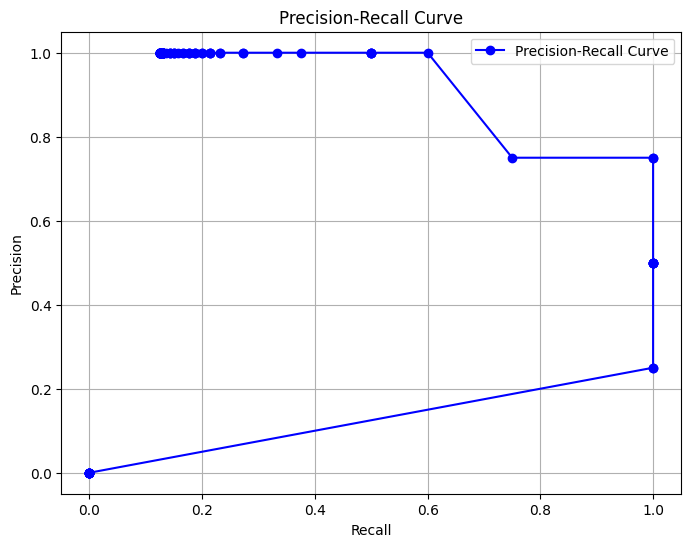

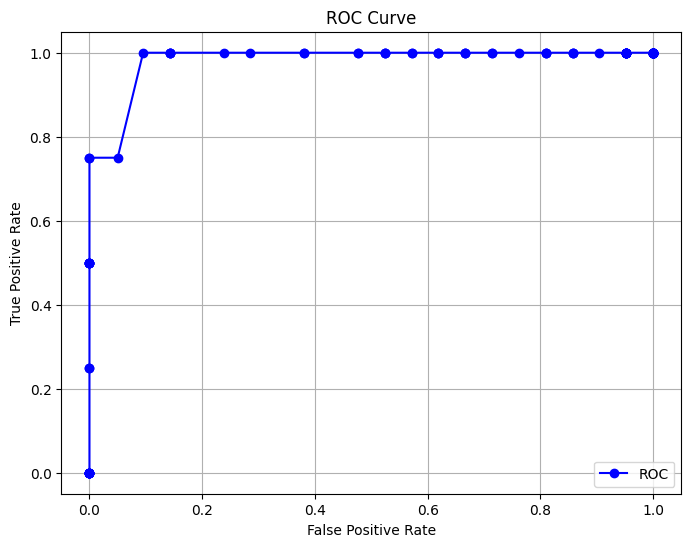

Actors ROC AUC: 0.9818452377257554
Actors Precision Recall Curve AUC: 0.7937499992902083


In [ ]:
# List of actors
generated_actors = [actor.name for actor in actors.actors]
manual_actors = [
    "Researchers", "Clinicians", "biologists", "Database Administrators", "Bioinformaticians", "Geneticists"
]

evaluator = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator.print_roc_prec_rec_curve(generated_actors, manual_actors)
print("Actors ROC AUC:", auc_roc)
print("Actors Precision Recall Curve AUC:", auc_prec_rec)